In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

### First load in the data

In [3]:
from pathlib import Path
import random


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import torch
import torch.utils.data


from src.data import DataPaths, Image, open_rgby

#### Load the training images

In [4]:
from pytorch_toolbox.fastai.fastai import vision

In [5]:
train_paths = [Path(DataPaths.TRAIN_IMAGES, img_id) for img_id in np.unique([p.name[:36] for p in DataPaths.TRAIN_IMAGES.glob("*")])]
test_paths = [Path(DataPaths.TEST_IMAGES, img_id) for img_id in np.unique([p.name[:36] for p in DataPaths.TEST_IMAGES.glob("*")])]

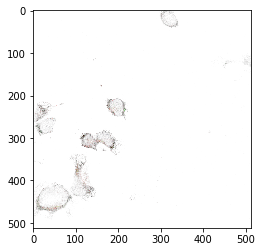

In [6]:
sample_path = random.sample(train_paths, 1)[0]
sample_img = open_rgby(sample_path)
plt.imshow(sample_img)

##### Image augmentation

In [7]:
from functools import partial

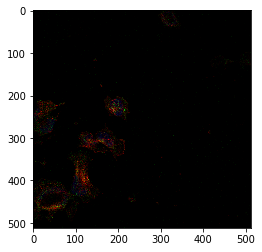

In [8]:
plt.imshow(sample_img.px[:,:,:3])

In [9]:
import numpy as np
from pytorch_toolbox.vision.transforms import simple_aug
from albumentations import Compose, Resize

def albumentations_transform_wrapper(image, augment_fn):
    augmentation = augment_fn(image=image.px)
    return augmentation['image']

resize_aug = Compose([Resize(height=128, width=128, always_apply=True)],p=1)
augment_fn = partial(albumentations_transform_wrapper, augment_fn=resize_aug)

Plot out the results

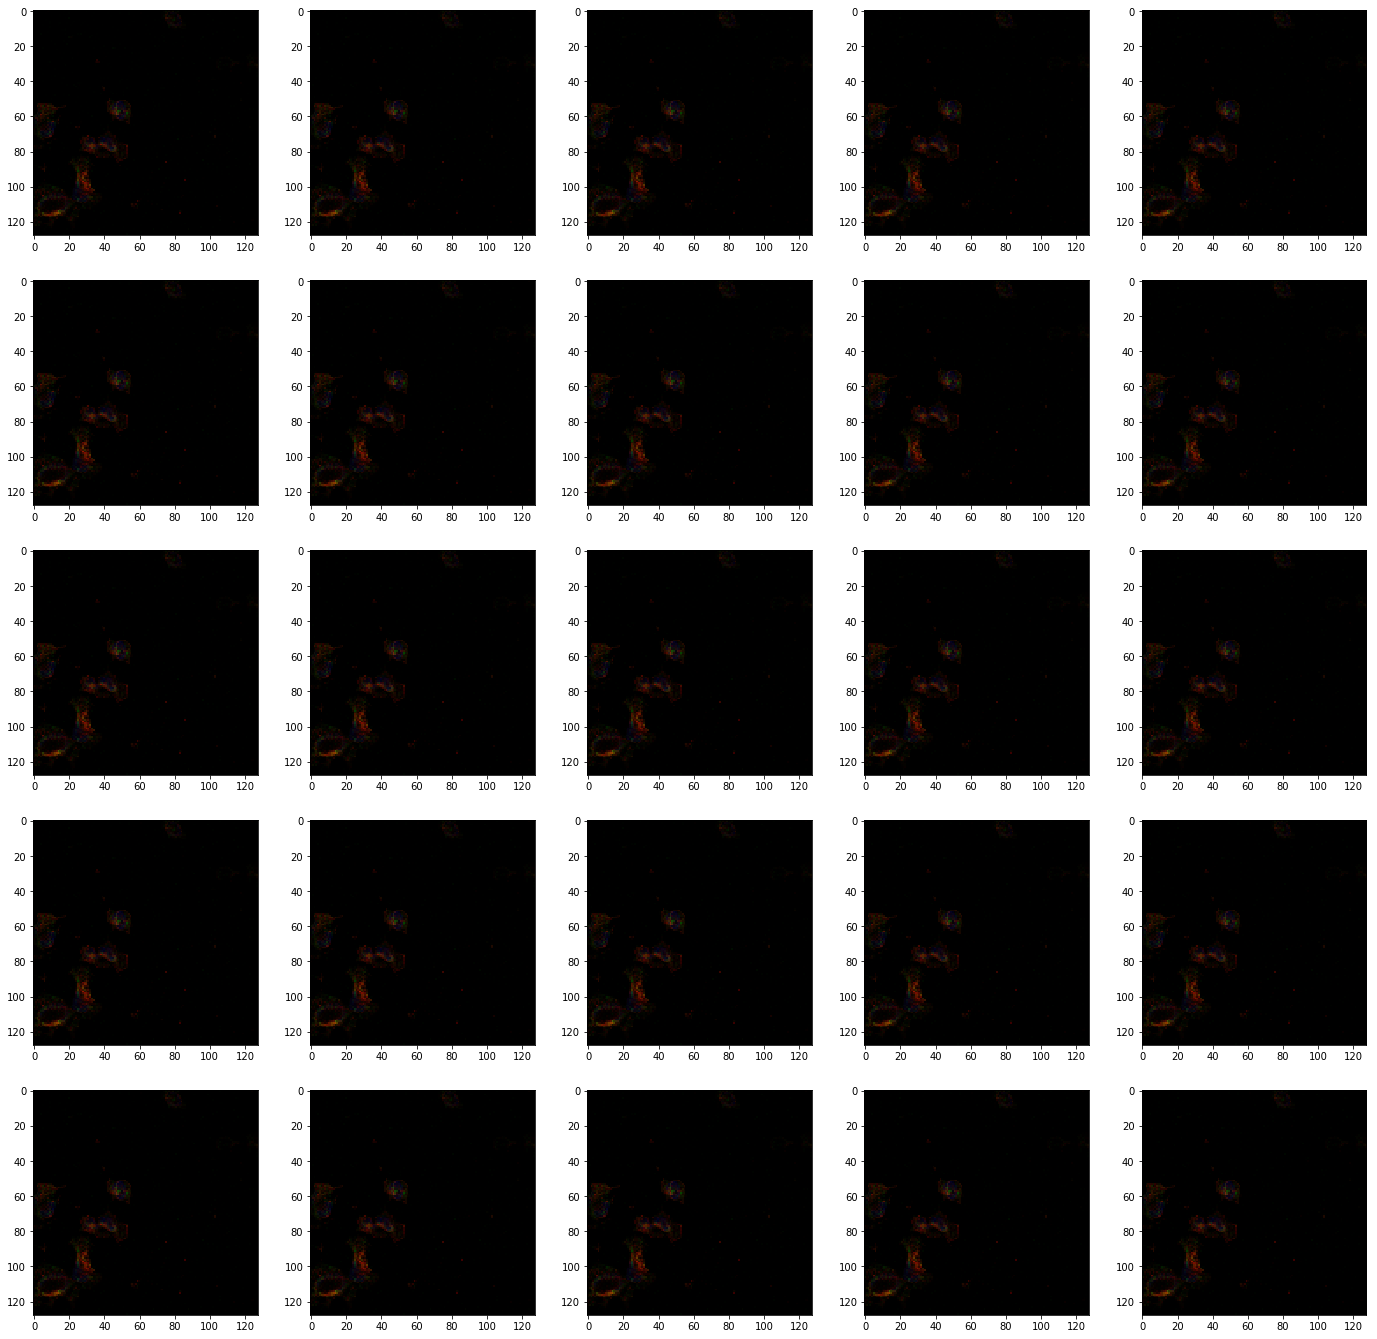

In [10]:
_, axs = plt.subplots(5, 5, figsize=(24, 24))
axs = axs.flatten()
for ax in axs:
    ax.imshow(augment_fn(sample_img)[:,:,:3])
#     ax.axis('off')

#### Load the training labels

In [11]:
labels_df = pd.read_csv(DataPaths.TRAIN_LABELS)
labels_df['Target'] = [[int(i) for i in s.split()] for s in labels_df['Target']]

In [12]:
labels_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18]


In [13]:
label = labels_df.loc[labels_df["Id"] == sample_path.name]['Target'].values[0]

In [14]:
label

[25]

##### Generate one hot labels

In [15]:
train_labels_one_hot = []
train_labels = labels_df['Target']
for labels in tqdm_notebook(train_labels):
    one_hot = np.zeros((28))
    for label in labels:
        one_hot[label] = 1
    train_labels_one_hot.append(one_hot.astype(np.float32))

In [16]:
# train_labels[0]
train_labels_one_hot[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

#### Now generate training input/label pairs

In [17]:
train_paths = sorted([Path(DataPaths.TRAIN_IMAGES, img_id) for img_id in np.unique([p.name[:36] for p in DataPaths.TRAIN_IMAGES.glob("*")])], key=lambda p: p.name)

In [18]:
labels_df = labels_df.sort_values(["Id"], ascending=[True])

In [19]:
np.all(np.array([p.name for p in train_paths]) == labels_df["Id"])

True

In [20]:
train_labels = labels_df["Target"].values

In [21]:
len(train_paths) == len(train_labels)

True

#### Load data into dataset

In [22]:
from functools import partial
from src.data import ProteinClassificationDataset
from pytorch_toolbox.utils.image import normalize, denormalize, tensor2img

Create a normalization function, as ImageNet is trained on 3 channel inputs, but our image is 4 channels we will use the pretrained weights from the first channel as the 4th channel, hence we will need to adjust our normalization function accordingly

In [23]:
four_channel_image_net_stats = {
    'mean': [0.485, 0.456, 0.406, 0.485],
    'sd': [0.229, 0.224, 0.224, 0.229]
}
four_channel_image_net_normalize = partial(normalize, **four_channel_image_net_stats)
four_channel_image_net_denormalize = partial(denormalize, **four_channel_image_net_stats)

In [24]:
ds = ProteinClassificationDataset(train_paths, image_cached=False, labels=train_labels_one_hot, augment_fn=augment_fn, normalize_fn=four_channel_image_net_normalize)

In [25]:
batch = next(iter(ds))
inp, name, label = batch['input'], batch['name'], batch['label']

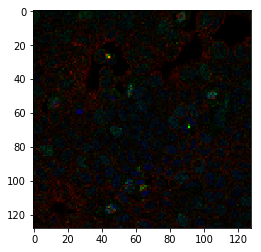

In [26]:
plt.imshow(tensor2img(inp, denorm_fn=four_channel_image_net_denormalize)[:,:,:3])

#### Define the loss to be used

In [27]:
import torch.nn as nn
from pytorch_toolbox.fastai_extensions.loss import LossWrapper, FocalLoss, SoftF1Loss

#### Create the data bunch

In [28]:
from functools import partial
from sklearn.model_selection import ShuffleSplit
from pytorch_toolbox.fastai_extensions.basic_data import DataBunch

In [29]:
shuffle_split_method = partial(ShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split, X=train_paths)

In [30]:
def get_splits(split_method):
    return next(iter(split_method()))

In [31]:
def create_data_bunch(split_method, augment_fn, normalize_fn, train_bs=64, val_bs=128, test_bs=128):
    train_idx, val_idx = get_splits(split_method)
    
    train_ds = ProteinClassificationDataset(inputs=np.array(train_paths)[train_idx], 
                                            image_cached=False,
                                            labels=np.array(train_labels_one_hot)[train_idx],
                                            augment_fn=augment_fn,
                                            normalize_fn=normalize_fn)
    val_ds = ProteinClassificationDataset(inputs=np.array(train_paths)[val_idx],
                                          image_cached=False,
                                          labels=np.array(train_labels_one_hot)[val_idx],
                                          normalize_fn=normalize_fn)
    test_ds = ProteinClassificationDataset(inputs=np.array(test_paths),
                                           image_cached=False,
                                           normalize_fn=normalize_fn)
    
    data = DataBunch.create(train_ds, val_ds, test_ds,
                            collate_fn=ProteinClassificationDataset.collate_fn,
                            train_bs=train_bs,
                            val_bs=val_bs,
                            test_bs=test_bs)
    return data

In [32]:
data = create_data_bunch(split_method=shuffle_split_method, 
                         augment_fn=augment_fn, normalize_fn=four_channel_image_net_normalize,
                         train_bs=32, val_bs=32, test_bs=32)

In [33]:
batch = next(iter(data.train_dl))

In [34]:
inp, name, label = batch[0], batch[1]['name'], batch[1]['label']

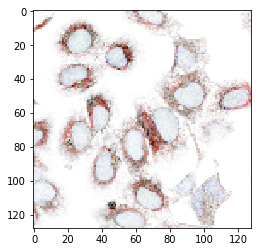

In [35]:
plt.imshow(tensor2img(inp[3], denorm_fn=four_channel_image_net_denormalize))

#### Initializing the model

In [36]:
import pytorch_toolbox.fastai.fastai as fastai
from pytorch_toolbox.fastai_extensions.basic_train import Learner
from src.models import cbam_resnet50_four_channel_input, resnet50_four_channel_input, resnet34_four_channel_input, resnet18_four_channel_input

In [37]:
# model = resnet50_four_channel_input(pretrained=False)
model = resnet18_four_channel_input(pretrained=True)
n_starting_layers = len(fastai.flatten_model(model[:6]))
n_middle_layers = len(fastai.flatten_model(model[6:9]))
n_head = len(fastai.flatten_model(model[9:]))
layer_groups = fastai.split_model_idx(model, [n_starting_layers, n_starting_layers + n_middle_layers])

../src/models.py:30: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)


#### Initialize callbacks

##### For extracting relevant information from output of our data bunch

In [38]:
from pytorch_toolbox.fastai_extensions.callbacks import NameExtractionTrainer

##### For saving the results of our training

In [39]:
from collections import defaultdict
from pytorch_toolbox.utils import to_numpy

In [40]:
class OutputRecorder(fastai.LearnerCallback):
    _order = -10

    def __init__(self, learn):
        super().__init__(learn)
        self.history = defaultdict(list)
        self.phase = None
        self.current_batch = dict()

    def on_batch_begin(self, last_input, last_target, epoch, train, **kwargs):
        if train:
            self.phase = 'TRAIN'
        else:
            label = last_target.get('label')
            if label is not None:
                self.phase = 'VAL'
            else:
                self.phase = 'TEST'
        self.key = (self.phase, epoch)
        inputs = tensor2img(last_input, denorm_fn=four_channel_image_net_denormalize)
        self.current_batch['input'] = inputs
        self.current_batch['name'] = last_target['name']
        if self.phase == 'TRAIN' or self.phase == 'VAL':
            label = to_numpy(last_target['label'])
            self.current_batch['label'] = label

    def on_loss_begin(self, last_output, epoch, **kwargs):
        model_output = to_numpy(last_output)
        self.current_batch['prediction_probs'] = model_output
        prediction = model_output.copy()
        prediction[prediction < 0.5] = 0
        prediction[prediction >= 0.5] = 1
        self.current_batch['prediction'] = prediction

    def on_batch_end(self, **kwargs):
        focal_loss = to_numpy(self.learn.loss_func.focal_loss.loss)
        f1_loss = to_numpy(self.learn.loss_func.soft_f1_loss.loss)
        self.current_batch['focal_loss'] = focal_loss
        self.current_batch['focal_loss_total'] = focal_loss.sum(axis=1)
        self.current_batch['f1_loss'] = f1_loss
        prediction = self.current_batch['prediction']
        label = self.current_batch['label']
        n_classes = label.shape[-1]
        indices_to_keep = np.where((prediction == label).sum(axis=1) != n_classes)[0]
        # indices_to_keep_losses = np.argsort(loss.sum(axis=1))[:int(len(label) * 0.1)]
        # if self.phase == "VAL":
        for idx in indices_to_keep:
            sample_to_save = dict()
            for k, v in self.current_batch.items():
                if k != "input":
                    sample_to_save[k] = v[idx]
            self.history[self.key].append(sample_to_save)

    def on_epoch_end(self, epoch, **kwargs):
        import pdb; pdb.set_trace()
        save_path = Path(f"results/{time.strftime('%Y%m%d-%H%M%S')}/epoch_{epoch}.csv")
        save_path.parent.mkdir(exist_ok=True, parents=True)
        history = self.history[self.key]
        df = pd.DataFrame(history)
        df.to_csv(save_path, index=False)
        self.history = defaultdict(list)

##### Define metric to track

In [41]:
from pytorch_toolbox.metrics import accuracy, f1_soft

#### Initialize Learner

In [42]:
learner = Learner(data,
                  layer_groups=layer_groups,
                  model=model, 
                  loss_func=LossWrapper([
                      FocalLoss(),
                      SoftF1Loss()
                  ]),
                  callbacks=[NameExtractionTrainer()],
                  callback_fns=[OutputRecorder],
                  metrics=[accuracy, f1_soft])

##### Find optimal learning rate

In [43]:
# import warnings
# warnings.filterwarnings('ignore')
# learner.lr_find(start_lr=[1e-5] * 3, end_lr=[1] * 3, num_it=250)
# learner.recorder.plot()

In [44]:
# learner.output_recorder.history

In [45]:
def iafoss_training_scheme(learner):
    lr = 2e-2
    lrs=np.array([lr/10,lr/3,lr])
    learner.unfreeze_layer_groups(2)
    learner.fit(epochs=1, lr=[0, 0, lr])
    learner.unfreeze()
    learner.fit_one_cycle(cyc_len=16, max_lr=lrs/4)
    learner.fit_one_cycle(cyc_len=8, max_lr=lrs/16)

In [47]:
iafoss_training_scheme(learner)

epoch,train_loss,valid_loss,accuracy,f1_soft


AttributeError: 'numpy.float64' object has no attribute 'detach'

In [ ]:
learner.save("iafoss.pth")

In [ ]:
learner.recorder.losses[-1]

In [ ]:
learner.save("cbam_resnet50_cyc_len=15, max_lr=[8e-3] * 3")

#### Define a recorder for the test results

In [ ]:
from pytorch_toolbox.utils.core import to_numpy

In [ ]:
class ResultRecorder(fastai.Callback):
    _order = -10
    def __init__(self):
        self.names = []
        self.prob_preds = []
        self.targets = []
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train:
            self.phase = 'TRAIN'
        else:
            label = last_target.get('label')
            if label is not None:
                self.phase = 'VAL'
            else:
                self.phase = 'TEST'
#         inputs = tensor2img(last_input, denorm_fn=image_net_denormalize)
#         self.inputs.extend(inputs)
        self.names.extend(last_target['name'])
        if self.phase == 'TRAIN' or self.phase == 'VAL':
            label = to_numpy(last_target['label'])
            self.targets.extend(label)
            
    def on_loss_begin(self, last_output, **kwargs):
        prob_pred = to_numpy(torch.sigmoid(last_output))
        self.prob_preds.extend(prob_pred)

##### Run prediction on learner

In [ ]:
learner.load("iafoss.pth")
res_recorder = ResultRecorder()
learner.predict_on_dl(dl=learner.data.valid_dl, callbacks=[res_recorder])

In [ ]:
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
pred_probs = np.stack(res_recorder.prob_preds)
targets = np.stack(res_recorder.targets)
print(targets.shape)
print(pred_probs.shape)

In [ ]:
name_label_dict = {
    0:  'Nucleoplasm',
    1:  'Nuclear membrane',
    2:  'Nucleoli',   
    3:  'Nucleoli fibrillar center',
    4:  'Nuclear speckles',
    5:  'Nuclear bodies',
    6:  'Endoplasmic reticulum',   
    7:  'Golgi apparatus',
    8:  'Peroxisomes',
    9:  'Endosomes',
    10:  'Lysosomes',
    11:  'Intermediate filaments',
    12:  'Actin filaments',
    13:  'Focal adhesion sites',   
    14:  'Microtubules',
    15:  'Microtubule ends',  
    16:  'Cytokinetic bridge',   
    17:  'Mitotic spindle',
    18:  'Microtubule organizing center',  
    19:  'Centrosome',
    20:  'Lipid droplets',
    21:  'Plasma membrane',   
    22:  'Cell junctions', 
    23:  'Mitochondria',
    24:  'Aggresome',
    25:  'Cytosol',
    26:  'Cytoplasmic bodies',   
    27:  'Rods & rings'
}

In [ ]:
th = fit_val(pred_probs,targets)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(targets, pred_probs>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(targets, pred_probs>0.5, average='macro'))
print('F1 micro: ',f1_score(targets, pred_probs>th, average='micro'))

In [ ]:
np.where(np.sum(pred_probs > th, axis=1)

##### Now use the optimal threshold for making predictions

In [ ]:
learner.load("iafoss.pth")
res_recorder = ResultRecorder()
learner.predict_on_dl(dl=learner.data.test_dl, callbacks=[res_recorder])

In [ ]:
names = np.stack(res_recorder.names)
pred_probs = np.stack(res_recorder.prob_preds)
print(names.shape)
print(pred_probs.shape)

In [ ]:
predicted = []
for pred in tqdm_notebook(pred_probs):
    classes = [str(c) for c in np.where(pred > th)[0]]
    if len(classes) == 0:
        classes = [str(np.argmax(pred[0]))]
    predicted.append(" ".join(classes))

In [ ]:
submission_df = pd.DataFrame({
    "Id": names,
    "Predicted": predicted
})

In [ ]:
submission_df

In [ ]:
submission_df.to_csv("submission.csv", index=False)